In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
noise_dim = 128

In [4]:
train_images = np.load('mnist_db.npy')

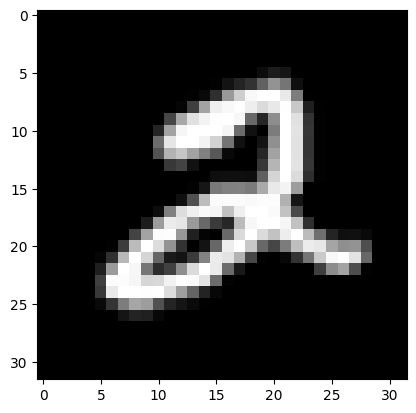

In [5]:
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [6]:
train_images = (train_images - 127.5) / 127.5

In [7]:
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", 
               use_bias=True, use_bn=False, use_dropout=False, drop_value=0.5):
    
    x = layers.Conv2D(filters, kernel_size, strides=strides, 
                      padding=padding, use_bias=use_bias)(x)
    
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
        
    return x

In [8]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same",
                   use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
    
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, 
                      padding=padding, use_bias=use_bias)(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
        
    return x

In [10]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    
    x = upsample_block(x, 128, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, 
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, 
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 1, layers.Activation("tanh"), strides=(1, 1), 
                       use_bias=False, use_bn=True)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization_4 (Bat  (None, 4096)              16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 8, 8, 256)         0         
 g2D)                                                    

In [11]:
def get_discriminator_model():
    
    img_input = layers.Input(shape=IMG_SHAPE)

    x = conv_block(img_input, 64, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)

    x = conv_block(x, 128, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    
    x = conv_block(x, 256, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=True, drop_value=0.3)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)       

In [ ]:
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, 
                 discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [ ]:
generator_optimizer = keras.optimizers.Adam(
	learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [ ]:
epochs = 20

# Instantiate the custom defined Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(discriminator=d_model,
			generator=g_model,
            latent_dim=noise_dim,
            discriminator_extra_steps=3,)

# Compile the WGAN model.
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Start training the model.
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

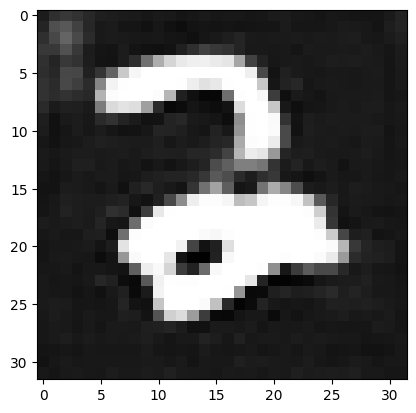

In [62]:
random_latent_vectors = tf.random.normal(shape=(1, noise_dim))
generated_images = wgan.generator(random_latent_vectors, training=False)
generated_images = (generated_images * 127.5) + 127.5
plt.imshow(generated_images[0], cmap='gray')
plt.show()

In [64]:
wgan.save_weights('wgan_mnist.h5')